In [1]:
"""
Import Libraries and define file names

Note that 'optional dependency' openpyxl is required to be installed for read_excel functionality
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter


file1 = 'Quarterly MySuper statistics September 2018 - September 2020.xlsx'
file2 = 'Quarterly MySuper statistics backseries September 2013 - June 2018.xlsx'

In [2]:
def Data_Cleaning(file1,file2):
    """
    Args: 
        file1, file2: strings which point to the location of either file
    
    Returns:
        Pandas Dataframe
    
    Part 1: Read in Data files
    """
    df_file1_1a = pd.read_excel(file1,sheet_name='Table 1a',skiprows=lambda x: x in [0,1,2,4,5]).dropna(how='all')
    df_file1_2a = pd.read_excel(file1,sheet_name='Table 2a',skiprows=lambda x: x in [0,1,2,3,5,6]).dropna(how='all')
    df_file2_1a = pd.read_excel(file2,sheet_name='Table 1a',skiprows=lambda x: x in [0,1,2,4,5]).dropna(how='all')
    df_file2_2a = pd.read_excel(file2,sheet_name='Table 2a',skiprows=lambda x: x in [0,1,2,3,5,6]).dropna(how='all')
    
    """
    Part 2: Subscript data files to the specified Column names to be used
    2.1 - Define Variable names to be used
    """
    include_cols_1a = ['Period',
                'MySuper product name',
                'Fund name',
                'Fund ABN',
                'Fund trustee',
                'Fund public offer status',
                'Fund type',
                'Total assets'
                ]

    include_cols_2a = ['Period',
                'MySuper product name',
                'Fund name',
                'Fund ABN',
                'Fund trustee',
                'Fund public offer status',
                'Fund type',
                'Total investment fees and costs (rep member)',
                'Net investment return',
                'Net return (rep member) - Quarterly']

    include_cols_join = list(set(include_cols_1a) & set(include_cols_2a))
    
    

    """
    2.2 - Strip newlines and double spaces to clean column names.  
    """
    def replace_all(text, dic):
        for i, j in dic.items():
            text = text.str.replace(i, j)
        return text
    
    df_file1_1a.columns = replace_all(df_file1_1a.columns,{'\n':'','  ':' '})
    df_file1_2a.columns = replace_all(df_file1_2a.columns,{'\n':'','  ':' '})
    df_file2_1a.columns = replace_all(df_file2_1a.columns,{'\n':'','  ':' '})
    df_file2_2a.columns = replace_all(df_file2_2a.columns,{'\n':'','  ':' '})

    """
    2.3 - Perform the subscript.  
    """
    
    df_file1_1a = df_file1_1a[include_cols_1a]
    df_file1_2a = df_file1_2a[include_cols_2a]
    df_file2_1a = df_file2_1a[include_cols_1a]
    df_file2_2a = df_file2_2a[include_cols_2a]
    
    """
    Part 3 - Merging the two sheets for each file on common variables

    Outer Join required since there are some funds in one sheet but not the other.  
    Null values will be included where appropriate
    """
    df_file1 = df_file1_1a.merge(df_file1_2a,how='outer',on=include_cols_join)
    df_file2 = df_file2_1a.merge(df_file2_2a,how='outer',on=include_cols_join)
    
    def NULL_report(df_tot,df_1a,df_2a):
        """
        Outputs a CSV file which gives diagnostic information for checking the number of Null values makes sense
        """
        null_df = pd.concat([
            pd.DataFrame(df_tot.isna().sum(),columns = ['Total']),
            pd.DataFrame(df_1a.isna().sum(),columns= ['1A']),
            pd.DataFrame(df_2a.isna().sum(),columns= ['2A'])
            ],axis=1)
        return null_df

    NULL_report(df_file1,df_file1_1a,df_file1_2a).to_csv('null_log_1.csv')
    NULL_report(df_file2,df_file2_1a,df_file2_2a).to_csv('null_log_2.csv')
    
    """
    Part 4 - Concatenate the two files from different time periods
    
    Two level index set so that the data for each individual fund within each reporting period can be quickly accessed
    Sorted by Fund. 
    
    4.1 - Concatenation
    """
    df_output = pd.concat([df_file1,df_file2],axis=0,ignore_index=True)
    
    """
    4.2 - Sorting 
    Need to sort manually this way since pandas sorting is case sensitive, and we require sorting over two levels
    """
    df_output['lower prod name'] = df_output['Fund name'].str.lower()  
    df_output = df_output.sort_values(['lower prod name','Period'])
    df_output.drop('lower prod name',axis=1,inplace=True)
    
    """
    4.3 - Indexing
    Set Multiindex to Fund name and Period.  
    Note that MySuper product name is not an appropriate choice of index since it is not unique.
    Seperate Funds may share the same MySuper product name.  
    """
    
    df_output.set_index(['Fund name', 'Period'],inplace=True)
    
    return df_output

In [3]:
df = Data_Cleaning(file1,file2)

In [4]:
def annualised_net_returns(quarterly_returns):
    """
    Calculates annualised net returns for an arbitrary time period in years 
    depending on the length of the input vector or array. 
    The function should take as input a vector/array of quarterly returns 
    and return the annualised net return for the correct number of years.
    
    Note - this implementation allows for arrays which do not evenly divide by 4.
    In this case, the function will discard the first 1-3 terms to ensure that the calculation uses
    the correct number of quarters.  
    
    Args: 
        quarterly_returns: A list which contains the last n quarterly returns
    
    Returns:
        Appropriate annualised net return for the correct number of years
    """
    years = np.floor(len(quarterly_returns) / 4)
    if years == 0:
        return
 
    geom_returns = (np.array(quarterly_returns)+1)[int(-years*4):]
    return (np.prod(geom_returns)**(1/years))-1

In [6]:
def sector_aggregates(df):
    """
    Returns the total asset weighted average annualised four-year net return 
    for each MySuper product fund type 
    using the clean dataset from Section 1 
    and the annualised return function you wrote for Section 2. 
    
    Args: 
        df: The clean dataset from Section 1
    
    Returns:
        Data series linking each fund type to an aggregate total asset weighted average annualised four-year net return
        
    Notes:  
    - Funds with less than four years of data are not used in this analysis
    - Funds may still be included if they are no longer current, so long as they have at least 4 years worth of data.
    - The most recent value for Total Assets is used to calculate total asset weightings for each fund.  
      This will be from the September 2020 quarter unless the fund is no longer current, in which case it will be from the
      latest quarter for which the fund has data.
    - Total Asset weightings are calculated within each fund type seperately.  
      Ie, the sum of weightings for funds within each fund type will be 1.  
      
    Part 1 - Take the Total assets from the latest time period of each fund, along with the Fund type  
    """

    df_products = (df.groupby('Fund name', as_index=True).last())[['Total assets','Fund type']]

    """
    1.2
    Several funds which have closed down have a Total Assets value of 0 in their most recent quarter.
    Total asset value for these funds are set to the 2nd most recent quarter.
    """
    for i,x in df_products.iterrows():
        if x['Total assets']==0:
            df_products.loc[i,'Total assets']=df.loc[i,'Total assets'].iloc[-2]
        
    """
    Part 2 - Use the annualised_net_returns function from Section 2 to 
             add the 4yr returns for each fund to df_products
    """
    
    for x in df_products.index:
        df_curr_fund = df.loc[x].iloc[-16:] #Takes the last 16 quarters for each fund
        quarterly_returns = df_curr_fund['Net return (rep member) - Quarterly'].values/100
        annualised_return = annualised_net_returns(quarterly_returns) #Calls the function from Section 2

        if annualised_return==None:
            #print ("'"+x+"' has been removed due to less than 4 quarters of data")
            df_products.loc[x,'4yr return'] = None
        else:
            df_products.loc[x,'4yr return'] = annualised_return
        
    df_products = df_products.sort_values('Fund type').dropna(subset=['4yr return']) #Only include funds with 4 years or more data

    """
    Part 3 - Weightings and Final Calculation
    
    3.1 - Calculate Total Asset Weightings for funds within each fund type
    """
    
    df_aggregates = df_products.groupby('Fund type')['Total assets'].sum()  #Total assets within each fund type
    df_products['Weighting'] = df_products['Total assets']/df_aggregates.loc[df_products['Fund type']].values
    
    """
    3.2 - Calculate Weighted 4yr return for each fund, and then aggregate to the level of Fund type
    """
    
    df_products['Weighted 4yr return'] = df_products['Weighting']*df_products['4yr return']
    df_aggregates = pd.DataFrame(df_aggregates)
    df_aggregates['Weighted Avg 4yr return'] = df_products.groupby('Fund type')['Weighted 4yr return'].sum()

    return df_aggregates['Weighted Avg 4yr return']

In [7]:
aggregates = sector_aggregates(df)
aggregates

Fund type
Corporate        0.060858
Industry         0.064168
Public Sector    0.061055
Retail           0.058311
Name: Weighted Avg 4yr return, dtype: float64

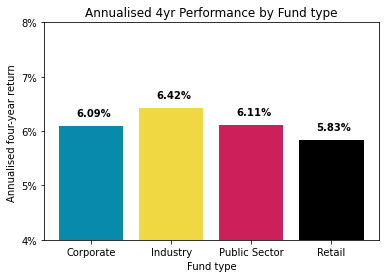

In [10]:
def display_image(aggregates):
    """
    Generates a chart based on the results of Section 3
    Args:
        aggregates - A data series containing the sector aggregates for total asset weighted average
                     annualised four-year net return for each MySuper product fund type
    Returns:
        Displays a matplotlib bar chart.  
    
    """
    fig, ax = plt.subplots()
    colours = np.array([(7,138,171),
           (239,216,66),
           (205,32,90),
           (0,0,0)])/255


    ax.yaxis.set_major_formatter(PercentFormatter(decimals=0))
    ax.set_ylim([4,8])
    ax.set_xlabel('Fund type')
    ax.set_ylabel('Annualised four-year return ')
    ax.set_title('Annualised 4yr Performance by Fund type')

    x = aggregates.index
    y = aggregates.values*100
    for i,j in zip(x,y):
        ax.annotate(str(round(j,2))+"%",xy=(i,j), xytext=(-15,10), textcoords='offset points',weight='bold')
    plt.bar(x,y,color=colours)
    plt.yticks(np.arange(4, 9, step=1))

    plt.show()
    
display_image(aggregates)